# Non-dominated Sorting Genetic Algorithm II
**Paper:** <https://sci-hub.se/10.1109/4235.996017>

## Problem: ZDT1

**Definition**

$f_1(x) = x_1$

$f_2(x) = g(x) h(f_1(x), g(x))$

where

$g(x) = 1 + \frac{9}{N-1} \sum_{i=2}^N x_i$

$h(f_1, g) = 1 - \sqrt{f_1/g}$

$0\leq x_i \leq 1 \quad i=1,...,N$

**Optimum**

$0\leq x_1^*\leq 1 \quad\&\quad x_i^*=0~\forall ~ i=2,...,N$

## Task: 
- Complete the selection module!
- Code doesn't need to be paper accurate, just makes it work!

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict

### Fitness

In [15]:
# Define the fitness functions: ZDT1
def get_fitness(x: np.ndarray):
    n = x.size
    f1 = x[0]
    g = 1 + 9 / (n - 1) * np.sum(x[1:])
    h = 1 - (f1 / g)**2
    f2 = g * h
    return f1, f2

### Individual

In [16]:
class Individual:
    def __init__(self, D, LB, UB):
        self.D = D   # problem dimensions
        self.LB = LB # lowerbound
        self.UB = UB # upperbound
        
        self.x = np.zeros(D) # vector of D dimensions
        self.fitnesses = None
    
    def random_gen(self):
        self.x = np.random.uniform(self.LB, self.UB, self.D)
        
    def evaluate(self):
        self.x = np.clip(self.x, self.LB, self.UB)
        self.fitnesses = get_fitness(self.x)
        
    def str_fitness(self):
        return '(' + ', '.join(['%.3f' % f for f in self.fitnesses]) + ')'

## Genetic operators

### SBX Crossover

In [17]:
def crossover(p1: Individual, p2: Individual, eta=1.0):
    u = np.random.random();
    if u < 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (0.5 / (1-u)) ** (1 / (eta + 1))
    c1 = Individual(p1.D, p1.LB, p1.UB)
    c2 = Individual(p1.D, p1.LB, p1.UB)
    c1.x = 0.5 * (p1.x + p2.x) - 0.5 * beta * abs(p1.x - p2.x)
    c2.x = 0.5 * (p1.x + p2.x) + 0.5 * beta * abs(p1.x - p2.x)
    return c1, c2

### Polynomial Mutation

In [18]:
def mutate(p: Individual, eta=1.0, lim=0.5):
    u = np.random.random();
    if u < 0.5:
        delta = (2 * u) ** (1 / (eta + 1)) - 1
    else:
        delta = 1 - (2 * (1 - u)) ** (1 / (eta + 1))
    
    mut_range = lim * (p.UB - p.LB)
#     c = Individual(p.D, p.LB, p.UB)
    p.x += delta * mut_range

## NSGA-II Selection

### Pareto dominance

In [19]:
def dominate(p1: Individual, p2: Individual):
    better = False
    for k in range(len(p1.fitnesses)):
        if p1.fitnesses[k] > p2.fitnesses[k]:
            return False
        if p1.fitnesses[k] < p2.fitnesses[k]:
            better = True
    return better

### Fast non-dominated sorting

In [20]:
def fast_non_dominated_sorting(pop: list):
    pn = np.zeros(len(pop), dtype=int)
    pS = defaultdict(list)
    for i, p in enumerate(pop):
        for j, q in enumerate(pop):
            if i == j: 
                continue
            if dominate(p, q):
                pn[j] += 1
                pS[i].append(j)
                
    paretos = [[i for i in range(len(pop)) if pn[i] == 0]]
    while True:
        next_pareto = []
        for i in paretos[-1]:
            for j in pS[i]:
                pn[j] -= 1
                if pn[j] == 0:
                    next_pareto.append(j)
        if len(next_pareto) == 0:
            break
        paretos.append(next_pareto)
        
    real_paretos = []
    for pr in paretos:
        real_paretos.append([pop[idx] for idx in pr])
#         print('Pareto:', [p.str_fitness() for p in real_paretos[-1]])
    
    return real_paretos

### Crowding distance

In [21]:
def assign_crowding_distance(pop: list):
    assert len(pop) > 1
    indices = list(range(len(pop)))
    I = np.zeros(len(pop), dtype=float)
    for k in range(len(pop[0].fitnesses)):
        fk = [p.fitnesses[k] for p in pop]
        indices = np.argsort(fk)
        
        lim = fk[indices[-1]] - fk[indices[0]]
        if lim < 1e-6:
            return np.zeros(len(pop), dtype=float)
        
        I[indices[0]] = I[indices[-1]] = 1e9
        for it in range(1, indices.size - 1):
            I[indices[it]] += (fk[indices[it + 1]] - fk[indices[it - 1]]) / lim
    return I

### Selection

In [22]:
def survival_selection(pop: list, pop_size: int):
    if len(pop) <= pop_size:
        return pop
    
    survivors = []
    paretos = fast_non_dominated_sorting(pop)
    for pareto in paretos:
        if len(survivors) + len(pareto) <= pop_size:
            survivors.extend(pareto)
            if len(survivors) == pop_size:
                break
        else:
            cd = assign_crowding_distance(pareto)
            indices = np.argsort(cd)[::-1]
            partial_pareto = [pareto[idx] for idx in indices[:(pop_size - len(survivors))]]
            survivors.extend(partial_pareto)
            break

    return survivors

## NSGA-II

In [23]:
def build_Pareto(pop: list):
    pareto = []
    for p in pop:
        for q in pareto:
            if dominate(q, p):
                break
        else:
            pareto = [q for q in pareto if not dominate(p, q)] + [p]
    return pareto

In [24]:
def evolve(D, LB, UB, pop_size: int, max_gen: int, crossover_rate=0.7, mutation_rate=0.1):
    # init
    population = []
    for _ in range(pop_size):
        p = Individual(D, LB, UB)
        p.random_gen()
        p.evaluate()
        population.append(p)
        
    # main loop
    for t in range(max_gen):
        # crossover
        offspring = []
        while len(offspring) < max_gen:
            parent1 = population[np.random.randint(0, pop_size - 1)]
            parent2 = population[np.random.randint(0, pop_size - 1)]

            if np.random.random() < crossover_rate:
                children = crossover(parent1, parent2)
                offspring.extend(children)
            else:
                offspring.extend([deepcopy(parent1), deepcopy(parent2)])
        
        # mutate
        for child in offspring:
            if np.random.random() < mutation_rate:
                mutate(child)
                
        # evaluate
        for child in offspring:
            child.evaluate()
            
        # selection
        population = survival_selection(population + offspring, pop_size)
#         if t % 10 == 0:
#             print(f'Populaton {t}: {[p.str_fitness() for p in population]}')
        
    
    # Pareto output
    pareto = build_Pareto(population)
    return pareto

## Simulation

In [25]:
# Problem
D = 10
LB = 0
UB = 1

# algorithm parameters
pop_size = 200
max_gen = 100

pareto = evolve(D, LB, UB, pop_size, max_gen)
# print('Final Pareto:')
# [p.str_fitness() for p in pareto]

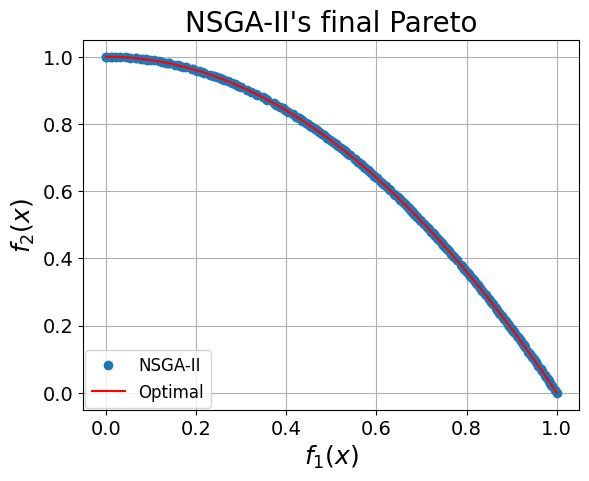

In [26]:
plt.cla()
plt.grid()
plt.title('NSGA-II\'s final Pareto', fontsize=20)
plt.xlabel('$f_1(x)$', fontsize=18)
plt.ylabel('$f_2(x)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# NSGA-II
front = [p.fitnesses for p in pareto]
front.sort()
plt.plot([p[0] for p in front], [p[1] for p in front], label='NSGA-II', marker='o', linestyle='None')

# Optimal Pareto
density = 1000
x = np.zeros([density, D], dtype=float)
x[:, 0] = np.linspace(0, 1, 1000)
plt.plot(x[:, 0], [get_fitness(xx)[1] for xx in x], color='red', label='Optimal')

plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=0.1, fontsize = 12)
plt.show()

# Multi-Objective Evolutionary Algorithm based on Decomposition (MOEA/D)
**Paper:** <https://sci-hub.se/10.1109/tevc.2007.892759>

## No exercise yet!!! (Yay)